# APL Custom Artifact 01: Pin Location Errors

Data provided by John Slotwinski on 3/25/2016 ("3D position check.pdf").


In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
%matplotlib inline 

import os, csv

import numpy as np
import pylab as plt
from mpl_toolkits.mplot3d import axes3d, art3d

import helpers as gpam


__author__ = "mjp"
__version__ = "0.0.1"
__status__ = "development"

__copyright__ = "Copyright 2016, JHU/APL"
__license__ = "Apache, Version 2.0"

In [3]:
def load_data(fn):
    """Loads data set from CSV file.
       fn : The .csv file to load.  Format is assumed to be:
            xNominal, xMeasured, yNominal, yMeasured, dNominal, dMeasured, zNominal, zMeasured

            where x, y, d, z are pin x-position, y-position, diameter and height.
            
    Note this data was measured in inches.
    We continue to employ the convention:
         delta_x := x_nominal - X_measured
    """
    X = []  # nominal pin locations
    Xm = [] # measured pin locations
    D = []  # pin location errors (deltas)
 

    cast = lambda row: [row[0].strip(),] + [float(x) for x in row[1:]]

    with open(fn, 'rU') as f:
        reader = csv.reader(f, delimiter=',')
        for rowIdx, row in enumerate(reader):
            if rowIdx == 0: continue # skip header

            pinId, xNom, xMeas, yNom, yMeas, dNom, dMeas, zNom, zMeas = cast(row)
            X.append((xNom, yNom))
            Xm.append((xMeas, yMeas))
            D.append((xNom - xMeas, yNom - yMeas))

    return np.array(X), np.array(Xm), np.array(D)


def plot_pins(Xn, Xm, units='(mm)'):
    plt.figure()
    plt.scatter(Xn[:,0], Xn[:,1], color='magenta')
    plt.scatter(Xm[:,0], Xm[:,1], color='blue')
    plt.legend(['nominal', 'measured'], loc='upper left')
    plt.plot([-52, 52], [0, 0], 'k-')
    plt.plot([0, 0], [-52, 52], 'k-')
    
    plt.xlabel('x location ' + units)
    plt.ylabel('y location ' + units)


In [4]:
Xn, Xm, D = load_data('/Users/pekalmj1/Documents/bb/gpam/data/APL01_M290_Maraging_steel/APL01_pin_features.csv')
assert(Xn.shape[0] == 50)  # there should be 50 pins

np.set_printoptions(formatter={'float_kind': lambda x: "%0.4f" % x})

#print "Nominal Pin locations"
#print Xn
#print "\n\nMeasured Pin locations"
#print Xm


# Convert to metric and calculate polar coordinates
mmPerInch = 25.4
Xn *= mmPerInch
Xm *= mmPerInch
D *= mmPerInch
rN, thetaN = gpam.cart2polar(Xn[:,0], Xn[:,1])  # nominal locations in polar coordinates

## APL01, Trial 1

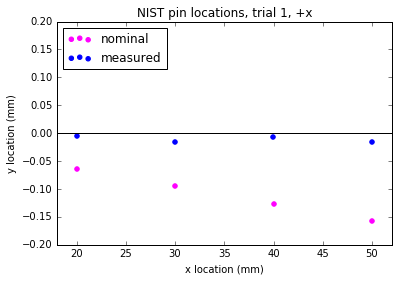

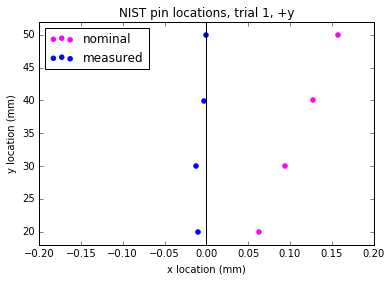

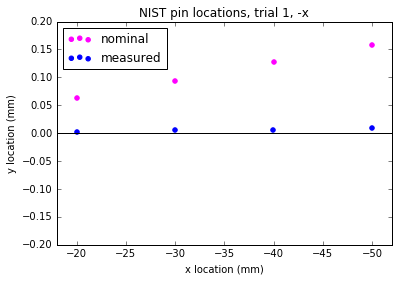

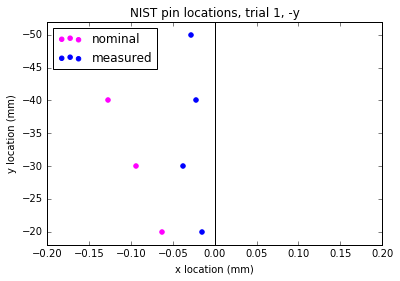

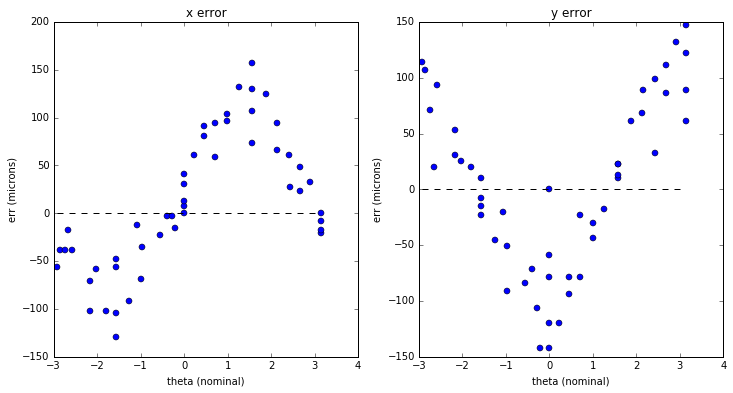

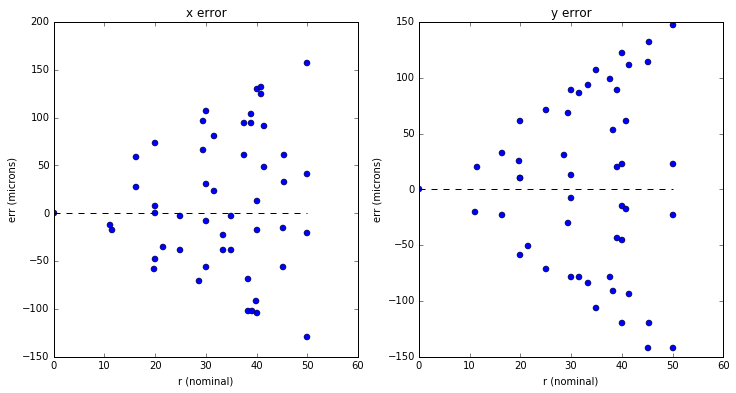

In [5]:
plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, +x')
plt.xlim([18, 52]);  plt.ylim([-.2, .2])

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, +y')
plt.xlim([-.2, .2]);  plt.ylim([18, 52])

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, -x')
plt.xlim([-18, -52]);  plt.ylim([-.2, .2])

plot_pins(Xn, Xm)
plt.title('NIST pin locations, trial 1, -y')
plt.xlim([-.2, .2]);  plt.ylim([-18, -52])

gpam.plot_xy_err_2d(thetaN, 1e3*D[:,0], 1e3*D[:,1], xLabel='theta (nominal)', yLabel='err (microns)')
gpam.plot_xy_err_2d(rN, 1e3*D[:,0], 1e3*D[:,1], xLabel='r (nominal)', yLabel='err (microns)')

## Fit a one-dimensional Gaussian process


Name                              : GP regression
Log-likelihood                    : -65.8651170138
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value      |  Constraint  |  Prior  |  Tied to
  Mat52.variance           |  55.4929439305  |     +ve      |         |         
  Mat52.lengthscale        |  1.70378288769  |     +ve      |         |         
  Gaussian_noise.variance  |  5.15069178123  |     +ve      |         |         

Name                              : GP regression
Log-likelihood                    : -72.1939692723
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value      |  Constraint  |  Prior  |  Tied to
  Mat52.variance           |   71.188988974  |     +ve      |         |         
  Mat52.lengthscale        |  2.08920149179  |     +

 /Users/pekalmj1/anaconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


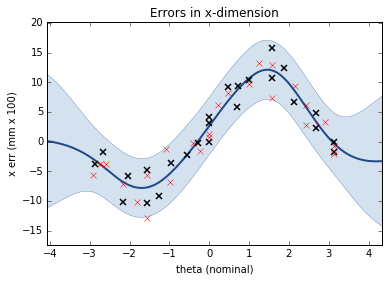

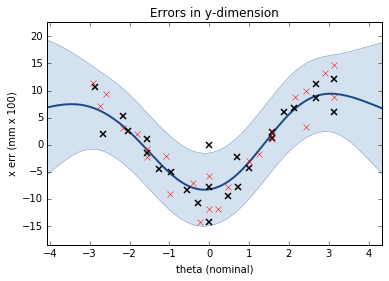

In [6]:
import GPy

# For visualization purposes, show GP fit to all measured data.
# We'll do some loo analysis later on.

def to_col(v): 
    return np.reshape(v, (v.size,1))

# Choose scale factor sf so that x and y are of similar magnitude
sf = 1e2
units = 'mm x %g' % sf
trainIdx = np.arange(0, thetaN.size, step=2)
testIdx = np.arange(1, thetaN.size, step=2)

_x = thetaN
dx = sf * D[:,0]
dy = sf * D[:,1]

kernel = GPy.kern.Matern52(1, ARD=False, lengthscale=1.)
model = GPy.models.GPRegression(to_col(_x[trainIdx]), to_col(dx[trainIdx]), kernel)
model.optimize(messages=True, max_f_eval=1000)
print model
model.plot()
plt.plot(_x[testIdx], dx[testIdx], 'rx')
plt.xlabel('theta (nominal)')
plt.ylabel('x err (%s)' % units)
plt.title('Errors in x-dimension')


model = GPy.models.GPRegression(to_col(_x[trainIdx]), to_col(dy[trainIdx]), kernel)
model.optimize(messages=True, max_f_eval=1000)
print model
model.plot()
plt.plot(_x[testIdx], dy[testIdx], 'rx')
plt.xlabel('theta (nominal)')
plt.ylabel('x err (%s)' % units)
plt.title('Errors in y-dimension')


Name                              : GP regression
Log-likelihood                    : -141.008703361
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |      Value       |  Constraint  |  Prior  |  Tied to
  Mat52.variance           |   2895.59751197  |     +ve      |         |         
  Mat52.lengthscale        |  0.252989935811  |     +ve      |         |         
  Gaussian_noise.variance  |    2308.1488366  |     +ve      |         |         

Name                              : GP regression
Log-likelihood                    : -142.445970199
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |        Value        |  Constraint  |  Prior  |  Tied to
  Mat52.variance           |  1.23195228302e-15  |     +ve      |         |         
  Mat52.lengthscale        |  1.23195228

 /Users/pekalmj1/anaconda2/lib/python2.7/site-packages/GPy/core/parameterization/transformations.py:80: RuntimeWarning:overflow encountered in exp


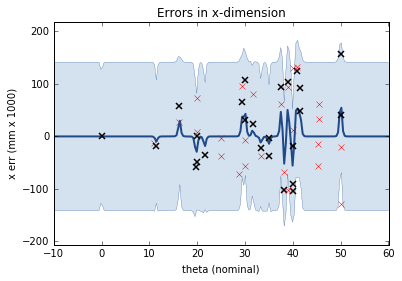

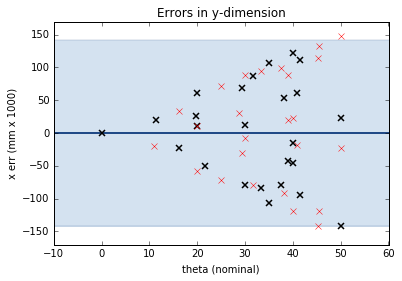

In [7]:
# also look as a function of r

# Choose scale factor sf so that x and y are of similar magnitude
sf = 1e3
units = 'mm x %g' % sf
trainIdx = np.arange(0, rN.size, step=2)
testIdx = np.arange(1, rN.size, step=2)

_x = rN
dx = sf * D[:,0]
dy = sf * D[:,1]

kernel = GPy.kern.Matern52(1, ARD=False, lengthscale=1.)
model = GPy.models.GPRegression(to_col(_x[trainIdx]), to_col(dx[trainIdx]), kernel)
model.optimize(messages=True, max_f_eval=1000)
print model
model.plot()
plt.plot(_x[testIdx], dx[testIdx], 'rx')
plt.xlabel('theta (nominal)')
plt.ylabel('x err (%s)' % units)
plt.title('Errors in x-dimension')


model = GPy.models.GPRegression(to_col(_x[trainIdx]), to_col(dy[trainIdx]), kernel)
model.optimize(messages=True, max_f_eval=1000)
print model
model.plot()
plt.plot(_x[testIdx], dy[testIdx], 'rx')
plt.xlabel('theta (nominal)')
plt.ylabel('x err (%s)' % units)
plt.title('Errors in y-dimension')

## 2D example

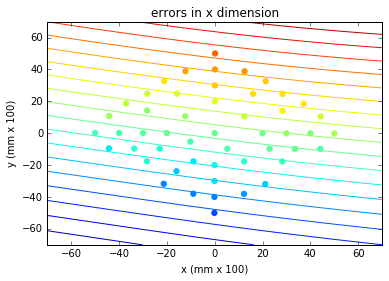

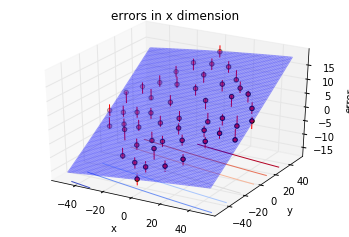

In [18]:
# We'll do some loo analysis later on.

# Choose scale factor sf so that x and y are of similar magnitude
sf = 1e2
units = 'mm x %g' % sf
dx = sf * D[:,0]

kernel = GPy.kern.Matern52(2, ARD=False, lengthscale=10.)
model = GPy.models.GPRegression(Xn, to_col(dx), kernel)
model.optimize(messages=True, max_f_eval=1000)
#print model
model.plot()
plt.title('errors in x dimension')
plt.xlabel('x (%s)' % units)
plt.ylabel('y (%s)' % units)


gpam.plot_gp_mean_2d(model, Xn, to_col(dx))
plt.title('errors in x dimension')

## LOO Kernel analysis

In [9]:
# Compare a few kernels

ker1 = GPy.kern.Matern52(1, ARD=False, lengthscale=1.)
ker2 = GPy.kern.RBF(1, lengthscale=1.)


err1, yHat1 = gpam.loo_err_1d(ker1, thetaN, dx)
err2, yHat2 = gpam.loo_err_1d(ker2, thetaN, dx)

plt.plot(np.arange(_y.size), _y, 'kx', 
         np.arange(_y.size), yHat1, 'ro',
         np.arange(_y.size), yHat2, 'go')
plt.legend(['measured', 'Matern', 'RBF'], loc='lower right')
plt.show()

print err1, err2

NameError: name '_y' is not defined